In [1]:
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# !pip install xarray
# !pip install xclim[extras]
# !pip install openpyxl

In [2]:
import pandas as pd
import xarray as xr
import xclim.sdba as sdba
from xclim import set_options

c:\Users\lucas\OneDrive\Documents\VSCode\Mel Bias Adjust\.venv\Lib\site-packages\xclim\sdba.py:12: UserWarning: The `xclim.sdba` module has been split into its own package `xsdba`. Users are encouraged to use `xsdba` directly. For the time being, `xclim.sdba` will import `xsdba` to allow for API compatibility. This behaviour may change in the future. For more information, see: https://xsdba.readthedocs.io/en/stable/xclim_migration_guide.html
  warnings.warn(


In [16]:
# -------------------------------
# STEP 1: Load data from Excel
# -------------------------------
# Assume we have an Excel file with two sheets:
#   - "obs" containing observed station data (Edmonton Blatchford)
#   - "model" containing one GCM/RCM model run
#
# Columns: ["date", "Tmax", "Tmin"]
# Dates must be converted to datetime for Xclim to work properly.

obs_df = pd.read_excel("./Data/Edmonton_Blatchford_Joined.xlsx")
model_df = pd.read_excel("./Data/Edmonton_Tmin_Cannon_16_Compiled .xlsx")

# Convert 'date' column to datetime
obs_df["date"] = pd.to_datetime(obs_df["DATE"])
model_df["date"] = pd.to_datetime(model_df["ALL DATES"])

import numpy as np

# -------------------------------
# STEP 1.5: Replace invalid values with NaN
# -------------------------------

# Replace -9999.9 or any large negative placeholder in obs and model
obs_df["Tmin"] = obs_df["Tmin"].replace(-9999.9, np.nan)
model_df["tasmin_FGOALS-g3_historical_ssp245_(degC)"] = model_df["tasmin_FGOALS-g3_historical_ssp245_(degC)"].replace(-9999.9, np.nan)

# Optional: also handle other placeholders if they exist, e.g. -999, -99.9
# obs_df["Tmin"].replace([-999, -99.9], np.nan, inplace=True)
# model_df["tasmin_FGOALS-g3_historical_ssp245_(degC)"].replace([-999, -99.9], np.nan, inplace=True)

# -------------------------------
# Continue with the rest of your code
# -------------------------------

In [4]:
model_df

,ALL DATES,tasmin_KACE-1-0-G_historical_ssp245_(degC),tasmin_GFDL-ESM4_historical_ssp245_(degC),tasmin_NorESM2-LM_historical_ssp245_(degC),tasmin_INM-CM5-0_historical_ssp245_(degC),tasmin_KIOST-ESM_historical_ssp245_(degC),tasmin_CMCC-ESM2_historical_ssp245_(degC),tasmin_FGOALS-g3_historical_ssp245_(degC),tasmin_BCC-CSM2-MR_historical_ssp245_(degC),tasmin_CNRM-ESM2-1_historical_ssp245_(degC),tasmin_MIROC-ES2L_historical_ssp245_(degC),tasmin_MIROC6_historical_ssp245_(degC),tasmin_MPI-ESM1-2-LR_historical_ssp245_(degC),tasmin_MRI-ESM2-0_historical_ssp245_(degC),tasmin_ACCESS-ESM1-5_historical_ssp245_(degC),tasmin_MPI-ESM1-2-HR_historical_ssp245_(degC),tasmin_ACCESS-CM2_historical_ssp245_(degC),date
0,1950-01-01,-9.181352,-30.180815,-13.112076,-18.583960,-20.454716,-39.134808,-12.663461,-40.544743,-16.960400,-18.751810,-12.123291,-18.416111,-19.832148,-22.426182,-17.308306,-26.524754,1950-01-01
1,1950-01-02,-9.440756,-33.879600,-36.311890,-16.069273,-16.816965,-19.978634,-14.332797,-29.240860,-25.944910,-17.949184,-18.739601,-25.474934,-13.490500,-8.134583,-19.349962,-23.173874,1950-01-02
2,1950-01-03,-9.828335,-33.574420,-40.154110,-10.536353,-29.964136,-21.965359,-19.053938,-11.598381,-32.323180,-12.074462,-12.135498,-29.167616,-11.674676,-10.258639,-15.828181,-17.439533,1950-01-03
3,1950-01-04,-8.775462,-36.208126,-37.618060,-6.990157,-24.943920,-26.408785,-24.174864,-15.608451,-31.612110,-10.130463,-14.402988,-11.454946,-17.686730,-9.462118,-12.626839,-24.458683,1950-01-04
4,1950-01-05,-18.693825,-21.641867,-38.063625,-13.469136,-25.969326,-24.065000,-26.802467,-18.532080,-22.877848,-11.345081,-17.665367,-9.977873,-32.683292,-11.808955,-9.102005,-31.764702,1950-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55147,2100-12-27,-5.369649,-4.335087,-7.872128,-30.916300,-14.436559,-22.102690,-11.842526,-2.012665,-3.624017,-17.714195,-10.341038,-12.361332,-24.306093,-8.717478,-4.942397,-11.027694,2100-12-27
55148,2100-12-28,-3.327992,-7.188524,-13.270769,-31.071941,-16.453800,-24.330507,-7.960630,-3.254749,-6.877240,-18.941021,-10.621803,-12.227053,-16.557562,-7.624932,-6.907758,-9.932096,2100-12-28
55149,2100-12-29,-6.626992,-9.733728,-8.964674,-30.257110,-18.852518,-19.716179,-5.882352,-3.904783,-8.577095,-18.397800,-8.851757,-12.300296,-13.768213,-17.326616,-10.313571,-9.068436,2100-12-29
55150,2100-12-30,-8.900586,-5.766384,-18.687721,-31.773857,-14.604407,-17.409016,-10.325779,-4.539558,-5.503928,-17.689781,-9.584190,-9.324787,-11.418324,-13.878078,-9.785609,-12.407109,2100-12-30


In [5]:
# -------------------------------
# STEP 2: Convert to xarray DataArrays
# -------------------------------
# Xclim works best with xarray DataArrays (time-indexed)
# Here we create separate DataArrays for Tmax and Tmin

obs_tmin = xr.DataArray(
    obs_df["Tmin"].values,
    dims="time",
    coords={"time": obs_df["date"]},
    attrs={"units": "degC"},
)

model_tmin = xr.DataArray(
    model_df["tasmin_FGOALS-g3_historical_ssp245_(degC)"].values,
    dims="time",
    coords={"time": model_df["date"]},
    attrs={"units": "degC"},
)

# Repeat for Tmax if needed (same pattern)

In [6]:
# -------------------------------
# STEP 3: Define training periods
# -------------------------------
# The user wants to test 30, 50, and 70-year windows
# Example: training period for quantile mapping = 1971-2000

train_slice_30yr = slice("1971-01-01", "2000-12-31")
train_slice_50yr = slice("1951-01-01", "2000-12-31")
train_slice_70yr = slice("1931-01-01", "2000-12-31")

In [7]:
# =====================================================
# STEP 4: Train quantile mapping models
# =====================================================
# Xclim provides "EmpiricalQuantileMapping" (EQM).
# - It looks at the distribution (not just the mean)
# - It maps quantiles of the model data onto the quantiles
#   of the observed data.
#
# In other words: "For a given percentile, how much is the
# model biased compared to observations?" and corrects it.
# =====================================================


# Align obs and model on common time steps for the 50-yr window
obs_30 = obs_tmin.sel(time=train_slice_50yr)
mod_30 = model_tmin.sel(time=train_slice_50yr)
obs_30, mod_50 = xr.align(obs_30, mod_30, join="inner")

QM_30 = sdba.EmpiricalQuantileMapping.train(
    ref=obs_30,
    hist=mod_30
)

# Align obs and model on common time steps for the 50-yr window
obs_50 = obs_tmin.sel(time=train_slice_50yr)
mod_50 = model_tmin.sel(time=train_slice_50yr)
obs_50, mod_50 = xr.align(obs_50, mod_50, join="inner")

QM_50 = sdba.EmpiricalQuantileMapping.train(
    ref=obs_50,
    hist=mod_50
)

# Align obs and model on common time steps for the 70-yr window
obs_70 = obs_tmin.sel(time=train_slice_70yr)
mod_70 = model_tmin.sel(time=train_slice_70yr)
obs_70, mod_70 = xr.align(obs_70, mod_70, join="inner")

QM_70 = sdba.EmpiricalQuantileMapping.train(
    ref=obs_70,
    hist=mod_70
)

In [8]:
# =====================================================
# STEP 5: Apply corrections
# =====================================================
# Once trained, the EQM models can be applied to *all*
# model data (past, present, and future).
# This step actually adjusts the model values.
# =====================================================

tmin_corrected_30 = QM_30.adjust(model_tmin)   # corrected with 30-yr training
tmin_corrected_50 = QM_50.adjust(model_tmin)   # corrected with 50-yr training
tmin_corrected_70 = QM_70.adjust(model_tmin)   # corrected with 70-yr training


In [14]:
# =====================================================
# STEP 6: Exceedance probability
# =====================================================
# Example: What is the probability Tmax exceeds 30°C?
# - We calculate it for raw model data
# - Then compare with bias-adjusted results
# =====================================================

threshold = 0  # degrees Celsius

# Probability (fraction of days) exceeding threshold
prob_raw = (model_tmin > threshold).mean().item()
prob_corrected_30 = (tmin_corrected_30 > threshold).mean().item()
prob_corrected_50 = (tmin_corrected_50 > threshold).mean().item()
prob_corrected_70 = (tmin_corrected_70 > threshold).mean().item()

# Print results
print(f"Raw exceedance probability: {prob_raw:.3f}")
print(f"Bias-adjusted (30yr window): {prob_corrected_30:.3f}")
print(f"Bias-adjusted (50yr window): {prob_corrected_50:.3f}")
print(f"Bias-adjusted (70yr window): {prob_corrected_70:.3f}")

Raw exceedance probability: 0.508
Bias-adjusted (30yr window): 0.573
Bias-adjusted (50yr window): 0.573
Bias-adjusted (70yr window): 0.572


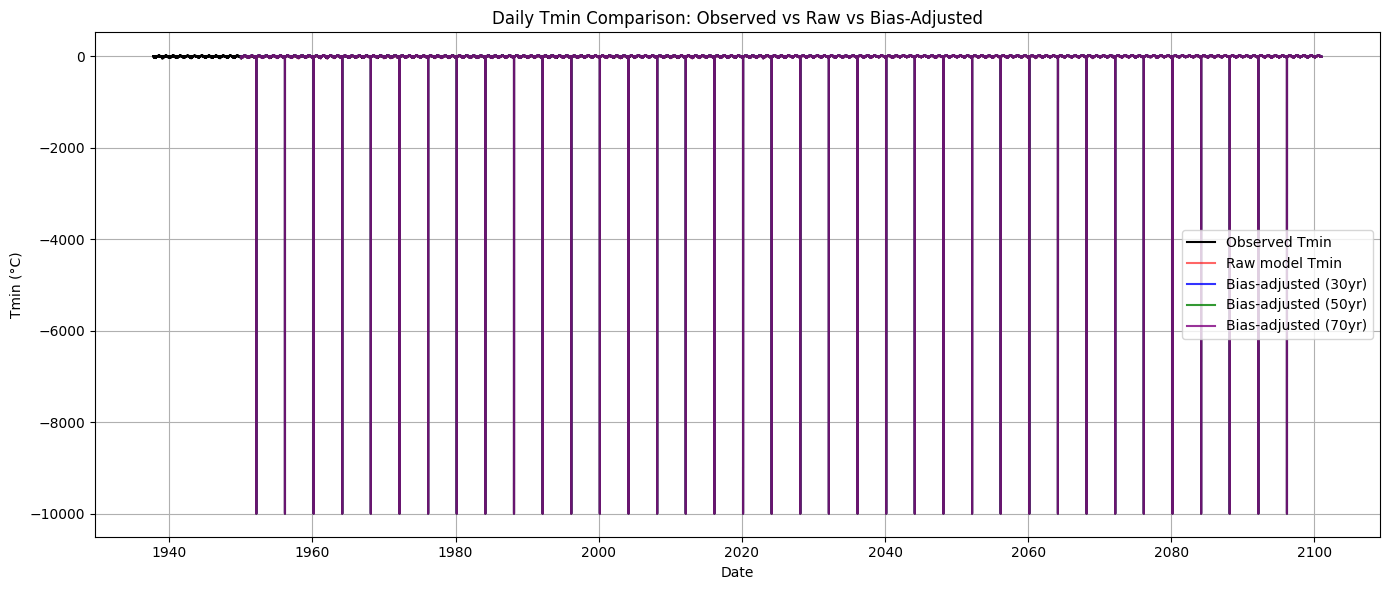

In [15]:
import matplotlib.pyplot as plt

# -------------------------------
# STEP 7: Plot comparison
# -------------------------------

plt.figure(figsize=(14,6))

# Plot observed Tmin
obs_tmin.plot(label="Observed Tmin", color="black", linewidth=1.5)

# Plot raw model Tmin
model_tmin.plot(label="Raw model Tmin", color="red", alpha=0.6)

# Plot bias-adjusted Tmin
tmin_corrected_30.plot(label="Bias-adjusted (30yr)", color="blue", alpha=0.8)
tmin_corrected_50.plot(label="Bias-adjusted (50yr)", color="green", alpha=0.8)
tmin_corrected_70.plot(label="Bias-adjusted (70yr)", color="purple", alpha=0.8)

# Formatting
plt.title("Daily Tmin Comparison: Observed vs Raw vs Bias-Adjusted")
plt.xlabel("Date")
plt.ylabel("Tmin (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()